# Debug Cluster Changes

This notebook is a utility notebook for examining changes between the current branch and `master`.

## Setup

Libraries:

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import dvc.api

## Load Data

We need to load some data files.  We are primarily interested in the book genders.

### Current Book Genders

Load the current genders:

In [2]:
current = pd.read_parquet('book-links/cluster-genders.parquet')
current.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32185879 entries, 0 to 32185878
Data columns (total 2 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   cluster  int32 
 1   gender   object
dtypes: int32(1), object(1)
memory usage: 368.3+ MB


<AxesSubplot:xlabel='count', ylabel='gender'>

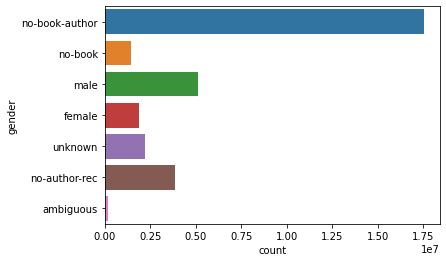

In [7]:
sns.countplot(y='gender', data=current)

In [13]:
current = current.set_index('cluster').sort_index()

### Master Book Genders

Now load the genders from the `master` branch:

In [9]:
with dvc.api.open('book-links/cluster-genders.parquet', rev='master', mode='rb') as pqf:
    master = pd.read_parquet(pqf)
master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32185879 entries, 0 to 32185878
Data columns (total 2 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   cluster  int32 
 1   gender   object
dtypes: int32(1), object(1)
memory usage: 368.3+ MB


In [12]:
master = master.set_index('cluster').sort_index()

### Authors

Let's load book first authors:

In [35]:
authors = pd.read_parquet('book-links/cluster-first-authors.parquet')
authors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24331117 entries, 0 to 24331116
Data columns (total 2 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   cluster      int32 
 1   author_name  object
dtypes: int32(1), object(1)
memory usage: 278.4+ MB


And the author indexes:

In [39]:
cur_au_idx = pd.read_parquet('viaf/author-name-index.parquet')
cur_au_idx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61678363 entries, 0 to 61678362
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   rec_id  uint32
 1   name    object
dtypes: object(1), uint32(1)
memory usage: 705.9+ MB


In [41]:
with dvc.api.open('viaf/author-name-index.parquet', rev='master', mode='rb') as pqf:
    old_au_idx = pd.read_parquet(pqf)
old_au_idx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61681353 entries, 0 to 61681352
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   rec_id  uint32
 1   name    object
dtypes: object(1), uint32(1)
memory usage: 705.9+ MB


## Examine Unmatched Books

Our initial question is to study why we have books without author records matching.

In [15]:
cur_nar_mask = current['gender'] == 'no-author-rec'
cur_nar_mask.describe()

count     32185879
unique           2
top          False
freq      28306911
Name: gender, dtype: object

In [16]:
old_nar_mask = master['gender'] == 'no-author-rec'
old_nar_mask.describe()

count     32185879
unique           2
top          False
freq      28303680
Name: gender, dtype: object

Get the books that are now NAR, but were not before:

In [25]:
newly_nar = cur_nar_mask & ~old_nar_mask
newly_nar.sum()

4806

<AxesSubplot:xlabel='count', ylabel='gender'>

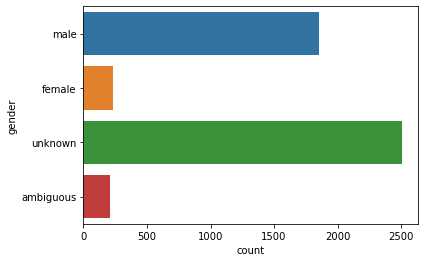

In [30]:
sns.countplot(y='gender', data=master[newly_nar])

Now let's try to look at why. What are these author names?

In [37]:
nnar = master[newly_nar]
nnar_auth = pd.merge(nnar.reset_index(), authors)
nnar_auth.head()

,cluster,gender,author_name
0,100000336,male,W Seiler
1,100000336,male,W. Seiler
2,100037838,female,L Divine
3,100038839,male,E Davies
4,100038921,male,W Brown


What does that look like in current data?

In [55]:
pd.merge(current[newly_nar].reset_index(), authors).head()

,cluster,gender,author_name
0,100000336,no-author-rec,W Seiler
1,100000336,no-author-rec,W. Seiler
2,100037838,no-author-rec,L Divine
3,100038839,no-author-rec,E Davies
4,100038921,no-author-rec,W Brown


Grab that first cluster.

In [42]:
sought = nnar_auth.iloc[:2, 2].tolist()
sought

['W Seiler', 'W. Seiler']

Find them in the old data:

In [44]:
matched = old_au_idx[old_au_idx['name'].isin(sought)]
matched

,rec_id,name
53193735,4121554,W Seiler


What does the current data say for that record?

In [49]:
cur_ver = cur_au_idx[cur_au_idx['rec_id'].isin(matched['rec_id'])].copy()
cur_ver['repr'] = cur_ver['name'].apply(repr)
cur_ver

,rec_id,name,repr
46783094,4121554,"Seiler, W","'Seiler, W'"
46783135,4121554,"Seiler, Wolfgang","'Seiler, Wolfgang'"
53190753,4121554,W Seiler,'W Seiler'
54710682,4121554,Wolfgang Seiler,'Wolfgang Seiler'


In [52]:
cur_ver.loc[53190753, 'name']

'W Seiler'